# Camera Pose Estimation
This notebook contains more detailed information on how to use the 7-scenes data set and apply the regression forest with consecutive RANSAC optimization. For detailed information regarding the implementation read our documentation in the `readme.md` file or inspect the comments in the code. For the mathematical background as well as architectural decisions please refer to the corresponding report.

At first, we show how to download and clean the data set for a certain scene. Then, the use of the Regresion Forest and RANSAC algorithm is shown and subsequently analyzed.

In [1]:
# We can not provide a full package yet and load our python files manually
import sys
sys.path.append('./source/')

***
## 1. Data Loading
In order to get started we first need to download data from the [**7-scenes dataset**](https://www.microsoft.com/en-us/research/project/rgb-d-dataset-7-scenes/). Therefore, just hop into the **/data** folder where you will find a notebook called **load_and_clean_7_scenes_dataset.ipynb**. Just pick a scene of your choice and execute the corresponding cell. 

To get an intuition for the data, we plot a number of `SAMPLES` of random images and corresponding depth maps from the data set `SCENE`. Additionally, the full volumetric image of the scene is displayed. 

Feel free to play around with different scenes in this notebook assuming the corresponding data set has been downloaded.

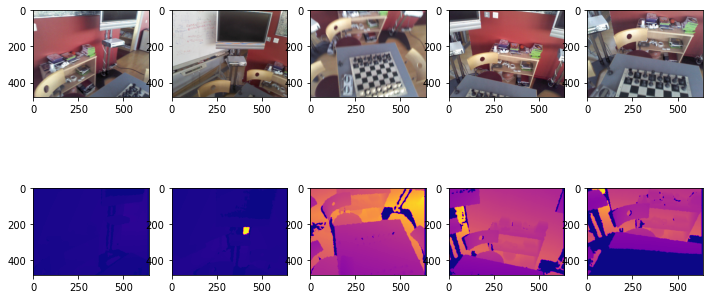

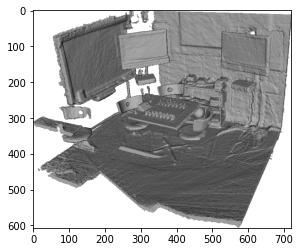

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from source.data_loader import DataLoader 

SCENE = "chess"         # one of the scenes (name of folder in /data)
DATA_PATH = "./data"    # directory where image data is stored
SAMPLES = 5             # images to display 

# load the data set
loader = DataLoader(DATA_PATH)
indices = np.random.choice(loader.get_dataset_length(SCENE), SAMPLES, replace = False)
images, depths, poses = loader.load_dataset(SCENE, indices)

# plot random images 
_, axes = plt.subplots(2, SAMPLES, figsize=(12,6))
for i in range(SAMPLES):
    axes[0,i].imshow(np.swapaxes(images[i], 1, 0))
    axes[1,i].imshow(depths[i].T, cmap=plt.get_cmap("plasma"))
plt.show()

# plot volume
full_scene = np.array(Image.open(f"./data/{SCENE}/{SCENE}.png"))
plt.imshow(full_scene)

***
## 2. Regression Forest
In this section we provide an approach on how to use our implementation of the Regression Forest. Therefore, we show any hyperparameters used for training and show the results of a trained forest. Look into the **/output** directory to get an overview of pre-trained forests.

### 2.1 Training
To train a forest for a certain scene we provide the script **/source/train_forest.py**. Initially, all hyperparameters must be set and are displayed in the following table:

| Hyperparameter | Default        | 
| ------------- |:-------------:| 
|TEST_SIZE | *0.5* |
|NUM_TREES | 5 |
|TREE_MAX_DEPTH | 16 |
|NUM_TRAIN_IMAGES_PER_TREE | 500 |
|NUM_SAMPLES_PER_IMAGE | 5000   |
|NUM_PARAMETER_SAMPLES | 1024 |
|FEATURE_TYPE | *DA_RGB / DEPTH* |

Make sure to  adjust the test size for each dataset since the values vary among different scenes. Subsequently, the dataset is loaded and split into training and test data. The forest is initialized and the training process started. When the training is finished, the forest object and corresponding parameters are saved in the **/output** folder.

Here, we load a trained forest and display the hypperparameters that have been used.

In [3]:
import os
from source.utils import load_object, millis

OUTPUT = "./output"
PREFIX = "25-03-2022_16-51_chess"    # folder which contains trained forest and parameters file

params = load_object(os.path.join(OUTPUT, PREFIX, f"params_{SCENE}.pkl"))
print(f'Loading forest trained on "{SCENE}"')

[print(f'\t{key}: {params[key]}') for key in [
    'TIMESTAMP',
    'TREE_MAX_DEPTH',
    'NUM_TREES',
    'NUM_TRAIN_IMAGES_PER_TREE',
    'NUM_SAMPLES_PER_IMAGE',
    'NUM_PARAMETER_SAMPLES',
    'FEATURE_TYPE']]
    
forest = load_object(os.path.join(OUTPUT, PREFIX, f"trained_forest_{SCENE}.pkl"))

Loading forest trained on "chess"
	TIMESTAMP: 25-03-2022_16-51
	TREE_MAX_DEPTH: 16
	NUM_TREES: 1
	NUM_TRAIN_IMAGES_PER_TREE: 500
	NUM_SAMPLES_PER_IMAGE: 5000
	NUM_PARAMETER_SAMPLES: 1024
	FEATURE_TYPE: FeatureType.DA_RGB


### 2.2 Testing
Now, we can use the trained forest and see how it performs on unseen data. Therefore, the forest is evaluated with randomly sampled test images. The number of test images is specified as `NUM_TEST_IMAGES` and the number of sampled pixels per image is defined as `NUM_SAMPLES_PER_IMAGE`. The resulting array contains the valid predictions of every tree in the forest. 

In [4]:
NUM_TEST_IMAGES = 500
NUM_SAMPLES_PER_IMAGE = 5000

# Sample images from test data set
test_set_indices = params['TEST_INDICES']
test_indices = np.random.choice(test_set_indices, NUM_TEST_IMAGES, replace = False)
images_data = loader.load_dataset(SCENE, test_indices)

# Obtain pixel and world coordinates from sample points
p_s, w_s = loader.sample_from_data_set(
    images_data = images_data,
    num_samples = NUM_SAMPLES_PER_IMAGE)

# Evalulate forest
print(f'Evaluating Forest with {NUM_TEST_IMAGES * NUM_SAMPLES_PER_IMAGE} samples per tree...')

start = millis()
forest_predictions = forest.evaluate(p_s, images_data)

print(f'Finished after {(millis() - start):5.1F}ms')

images_data = None # free memory

Evaluating Forest with 2500000 samples per tree...
Finished after 16700.0ms


### 2.3 Evaluation
Next up, we'll show the results of our training process for the different scenes and evaluate them.

In [5]:
from source.evaluator import SceneCoordinateEvaluator
from source.visualization import draw_pointcloud

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Due to the fact, that the feature generation process may lead to invalid features, we have a look at how many of the sampled point from the test data return a valid result.

In [6]:
eval = SceneCoordinateEvaluator()
valid_predictions = eval.get_valid_predictions(forest_predictions)

total_num_predictions = (NUM_TEST_IMAGES * NUM_SAMPLES_PER_IMAGE * params["NUM_TREES"])
valid_num_predictions = valid_predictions.shape[0]

print(f'The forest exhibits {(valid_num_predictions / total_num_predictions):.2%} valid predictions')

The forest exhibits 89.43% valid predictions


Next up, we calculate the average deviation of the predicted 3D cooordinate with respect to the ground truth. This is calculated for each tree in the forest and as total deviation. 

Tree 1: average deviation = [1.061E+00 +/- 3.983E-01] m

Total average deviation = [1.061E+00 +/- 3.983E-01] m


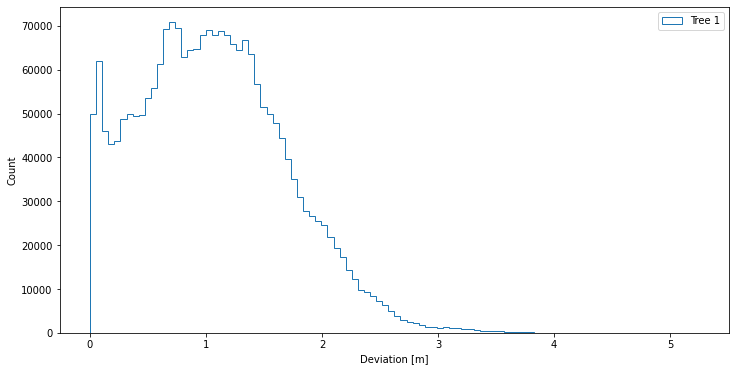

In [7]:
# calculate L2-norm error between predicted and ground truth world coordinates
errors = eval.get_prediction_error(forest_predictions, w_s)

# plot mean error and variance per tree
plt.figure(figsize=(12,6))
for i, err in enumerate(errors):
    plt.hist(err, bins=100, fill=False, histtype='step', label=f'Tree {i+1}')
    print(f'Tree {i+1}: average deviation = [{np.mean(err):1.3E} +/- {np.var(err):1.3E}] m')
    
plt.xlabel('Deviation [m]')
plt.ylabel('Count')
plt.legend()

# plot total error for forest
avg_deviation = np.mean([np.mean(err) for err in errors])
var_deviation = np.mean([np.var(err) for err in errors])

print(f"\nTotal average deviation = [{avg_deviation:1.3E} +/- {var_deviation:1.3E}] m")

For all forests the error is between 0 and 2 meters. This may look fairly bad, considering that the RANSAC samples random coordinates from the trees. But, due to the greedy optimization approach, the camera pose optimization still produces adequate results as shown in the sections below. However, there is still potential to optimize our Regression Forest.

Finally, we plot a pointcloud to show some fancy graphical results.

In [8]:
draw_pointcloud(valid_predictions) # opens an external window

## 3. Predicting Camera Poses

### 3.1 Evaluation

In [19]:
from source.evaluator import PoseEvaluator
import numpy as np

pose = np.stack([np.array([ 0.82956589,  0.25454269, -0.49701957, -0.13176393]),
np.array([-0.12786476,  0.95300385,  0.27465301, -0.81012114]),
np.array([ 0.54357248, -0.16429148,  0.82312652, -0.4613063 ]),
np.array([0., 0., 0., 1.])])

gt =   np.array([[8.3529902e-001,	  2.4256018e-001,	 -4.9329793e-001,	 -1.3914277e-001],	
 [-1.2293575e-001,	  9.5704353e-001	,  2.6242670e-001	, -7.9418439e-001],	
  [5.3579146e-001,	 -1.5856197e-001,	  8.2926470e-001,	 -4.6732929e-001],	
  [0.0000000e+000	,  0.0000000e+000,	  0.0000000e+000,	  1.0000000e+000]])

eval = PoseEvaluator()
error_translation = eval.get_translational_error(np.array([pose, pose]), np.array([gt,gt]))
error_angular = eval.get_angular_error(np.array([pose, pose]), np.array([gt,gt]))
print(error_translation)
print(error_angular)

eval.evaluate(np.array([pose, pose]), np.array([gt,gt]))

[0.0185662 0.0185662]
[1.14670409 1.14670409]


1.0